In [4]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from joblib import Parallel, delayed  
import os
import sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer





/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
pip install swifter sparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 8.2 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=37a45f688d4dd5b95d0d4c542a92d6d324948a3412ce9cc3c5e149fd255e629b
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sparse

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import swifter

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Dataset

In [7]:
df = pd.read_csv("/kaggle/input/cryptoredditdata/crypto_reddit_data_unlimited.csv")

## Viewing Dataset

In [8]:
df.head()

,id,user,title,text,score,created_utc,type,post_id,subreddit
0,7lusyi,Pracy_,Everytime Bitcoin drops,NaN,16627,1.514116e+09,post,7lusyi,ethtrader
1,g42ijd,bitusher,FAQ for Beginners,----------------------------------------------...,1619,1.587275e+09,post,g42ijd,bitcoinbeginners
2,ndh93e,Airenie,Billionaire's secret to playing coin🥱,NaN,6061,1.621143e+09,post,ndh93e,binance
3,ms96il,PorzingisDingus,When you’ve spent the past 4 years carefully r...,NaN,4815,1.618597e+09,post,ms96il,CryptoMarkets
4,1h6ykx6,Physical-Average2495,Bitcoin Hit 100k,NaN,53474,1.733366e+09,post,1h6ykx6,bitcoin


In [9]:
df.size

17589249

## Handling missing values

In [10]:
df.isnull().sum()

id                0
user              0
title             0
text           9718
score             0
created_utc       0
type              0
post_id           0
subreddit         0
dtype: int64

In [11]:
df.dropna(inplace=True)


In [12]:
df.isnull().sum()

id             0
user           0
title          0
text           0
score          0
created_utc    0
type           0
post_id        0
subreddit      0
dtype: int64

## Handling duplicate rows

In [13]:
df.duplicated().sum()

208428

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.duplicated().sum()

0

# Preprocessing the data

## Removing punctuation

In [16]:
def remove_punctuation(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    # Remove all punctuation
    return re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

In [17]:
df['cleaned_title'] = df['title'].apply(remove_punctuation)
df['cleaned_text'] = df['text'].apply(remove_punctuation)

In [18]:
df[['title', 'cleaned_title']]
df[['text', 'cleaned_text']]


,text,cleaned_text
1,----------------------------------------------...,...
5,----------------------------------\n\n**Some f...,\n\n Some f...
6,This subreddit is not a place where companies ...,This subreddit is not a place where companies ...
7,--------------------------------------------\n...,\n...
8,----------------------------------\n\n**Common...,\n\n Common...
...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,Link mirror Orderly Network Expands to Sei E...
1954357,With the low fees and high speed on SEI this c...,With the low fees and high speed on SEI this c...
1954358,Nice! Now even the giga whales can trade with ...,Nice Now even the giga whales can trade with ...
1954359,No question about that. We will start seeing s...,No question about that We will start seeing s...


## Removing newline

In [19]:
df = df.replace('\n', ' ', regex=True)

In [20]:
df[['title', 'cleaned_title']]

,title,cleaned_title
1,FAQ for Beginners,FAQ for Beginners
5,FAQ for Beginners,FAQ for Beginners
6,FAQ for Beginners,FAQ for Beginners
7,FAQ for Beginners,FAQ for Beginners
8,FAQ for Beginners,FAQ for Beginners
...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954357,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954358,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954359,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...


In [21]:
df[['text', 'cleaned_text']]

,text,cleaned_text
1,----------------------------------------------...,...
5,---------------------------------- **Some fou...,Some fou...
6,This subreddit is not a place where companies ...,This subreddit is not a place where companies ...
7,-------------------------------------------- *...,...
8,---------------------------------- **Common Q...,Common Q...
...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,Link mirror Orderly Network Expands to Sei E...
1954357,With the low fees and high speed on SEI this c...,With the low fees and high speed on SEI this c...
1954358,Nice! Now even the giga whales can trade with ...,Nice Now even the giga whales can trade with ...
1954359,No question about that. We will start seeing s...,No question about that We will start seeing s...


In [22]:
df.iloc[1].text

'----------------------------------  **Some foundational Principles of security**  If you don\'t own much value in Bitcoin these principles are not for you. There is no one solution and most people have different risk profiles and make multiple trade offs in a risk vs convenience spectrum.   1) **Never store your bitcoins in a web wallet or exchange . You own 0 bitcoins if you do not control your private keys.**  2) Do not trust strangers on the Internet to help you setup your personal wallet. This is someone you must do yourself or have a personal friend or family member help you with in real life where they cannot see your backup seed.   3) Buy your hardware wallet directly from the producer or amazon site under the producers name. Verify the integrity of the hardware wallet if you are extra paranoid :  https://trezor.io/learn/a/authenticate-trezor-safe-3  https://shiftcrypto.support/help/en-us/3-basics/1-bitbox02-unboxing  https://coldcard.com/docs/ultra-quick  https://help.blockstr

In [23]:
df['cleaned_title'] = df['cleaned_title'].str.replace(r'[-*]', '', regex=True).str.strip()
df['cleaned_text'] = df['cleaned_text'].str.replace(r'[-*]', '', regex=True).str.strip()

In [24]:
df[['title', 'cleaned_title']]

,title,cleaned_title
1,FAQ for Beginners,FAQ for Beginners
5,FAQ for Beginners,FAQ for Beginners
6,FAQ for Beginners,FAQ for Beginners
7,FAQ for Beginners,FAQ for Beginners
8,FAQ for Beginners,FAQ for Beginners
...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954357,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954358,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954359,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...


In [25]:
df[['text', 'cleaned_text']]

,text,cleaned_text
1,----------------------------------------------...,What is Bitcoin ...
5,---------------------------------- **Some fou...,Some foundational Principles of security If...
6,This subreddit is not a place where companies ...,This subreddit is not a place where companies ...
7,-------------------------------------------- *...,Bitcoin Beginners Rules ...
8,---------------------------------- **Common Q...,Common Questions What happens when all th...
...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,Link mirror Orderly Network Expands to Sei E...
1954357,With the low fees and high speed on SEI this c...,With the low fees and high speed on SEI this c...
1954358,Nice! Now even the giga whales can trade with ...,Nice Now even the giga whales can trade with ...
1954359,No question about that. We will start seeing s...,No question about that We will start seeing s...


## Removing numbers

In [26]:
def remove_numbers(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    return re.sub(r'\d+', '', text)


In [27]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)
df['cleaned_title'] = df['cleaned_title'].apply(remove_numbers)

In [28]:
df[['title', 'cleaned_title']]

,title,cleaned_title
1,FAQ for Beginners,FAQ for Beginners
5,FAQ for Beginners,FAQ for Beginners
6,FAQ for Beginners,FAQ for Beginners
7,FAQ for Beginners,FAQ for Beginners
8,FAQ for Beginners,FAQ for Beginners
...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954357,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954358,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...
1954359,Orderly Network Expands to Sei Ecosystem to Su...,Orderly Network Expands to Sei Ecosystem to Su...


In [29]:
df[['text', 'cleaned_text']]

,text,cleaned_text
1,----------------------------------------------...,What is Bitcoin ...
5,---------------------------------- **Some fou...,Some foundational Principles of security If...
6,This subreddit is not a place where companies ...,This subreddit is not a place where companies ...
7,-------------------------------------------- *...,Bitcoin Beginners Rules ...
8,---------------------------------- **Common Q...,Common Questions What happens when all th...
...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,Link mirror Orderly Network Expands to Sei E...
1954357,With the low fees and high speed on SEI this c...,With the low fees and high speed on SEI this c...
1954358,Nice! Now even the giga whales can trade with ...,Nice Now even the giga whales can trade with ...
1954359,No question about that. We will start seeing s...,No question about that We will start seeing s...


## Removing special characters

In [30]:
def remove_special_chars(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [31]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_special_chars)
df['cleaned_title'] = df['cleaned_title'].apply(remove_special_chars)

In [32]:
df[['title', 'cleaned_title']].iloc[500:505]

,title,cleaned_title
509,Billionaire's secret to playing coin🥱,Billionaire s secret to playing coin
510,Billionaire's secret to playing coin🥱,Billionaire s secret to playing coin
511,Billionaire's secret to playing coin🥱,Billionaire s secret to playing coin
512,Billionaire's secret to playing coin🥱,Billionaire s secret to playing coin
513,Billionaire's secret to playing coin🥱,Billionaire s secret to playing coin


In [33]:
df[['text', 'cleaned_text']].iloc[70000:70005]

,text,cleaned_text
70242,It's funny people complaining about this when ...,It s funny people complaining about this when ...
70243,Eth is the worst offender. last cycle when eve...,Eth is the worst offender last cycle when eve...
70244,I've been doing stuff on-chain all day and had...,I ve been doing stuff on chain all day and had...
70245,"Sir, this is a Wendy’s.",Sir this is a Wendys
70246,[](https://www.reddit.com/r/solana/comments/1i...,https www reddit com r solana comments iot c...


## Lowercasing the text

In [34]:
def lowercase_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    return text.lower()

In [35]:
df['cleaned_text'] = df['cleaned_text'].apply(lowercase_text)

In [36]:
df['cleaned_title'] = df['cleaned_title'].apply(lowercase_text)

In [37]:
df[['text', 'cleaned_text']]

,text,cleaned_text
1,----------------------------------------------...,what is bitcoin ...
5,---------------------------------- **Some fou...,some foundational principles of security if...
6,This subreddit is not a place where companies ...,this subreddit is not a place where companies ...
7,-------------------------------------------- *...,bitcoin beginners rules ...
8,---------------------------------- **Common Q...,common questions what happens when all th...
...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,link mirror orderly network expands to sei e...
1954357,With the low fees and high speed on SEI this c...,with the low fees and high speed on sei this c...
1954358,Nice! Now even the giga whales can trade with ...,nice now even the giga whales can trade with ...
1954359,No question about that. We will start seeing s...,no question about that we will start seeing s...


In [38]:
df[['title', 'cleaned_title']]

,title,cleaned_title
1,FAQ for Beginners,faq for beginners
5,FAQ for Beginners,faq for beginners
6,FAQ for Beginners,faq for beginners
7,FAQ for Beginners,faq for beginners
8,FAQ for Beginners,faq for beginners
...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands to sei ecosystem to su...
1954357,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands to sei ecosystem to su...
1954358,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands to sei ecosystem to su...
1954359,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands to sei ecosystem to su...


## Removing stopwords

In [39]:
def remove_stopwords_from_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)


In [40]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords_from_text)
df['cleaned_title'] = df['cleaned_title'].apply(remove_stopwords_from_text)

In [41]:
df[['title', 'cleaned_title']]

,title,cleaned_title
1,FAQ for Beginners,faq beginners
5,FAQ for Beginners,faq beginners
6,FAQ for Beginners,faq beginners
7,FAQ for Beginners,faq beginners
8,FAQ for Beginners,faq beginners
...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...
1954357,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...
1954358,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...
1954359,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...


In [42]:
df[['text', 'cleaned_text']]

,text,cleaned_text
1,----------------------------------------------...,bitcoin bitcoin scarce decentralized global di...
5,---------------------------------- **Some fou...,foundational principles security much value bi...
6,This subreddit is not a place where companies ...,subreddit place companies promote services pro...
7,-------------------------------------------- *...,bitcoin beginners rules bitcoin beginners subr...
8,---------------------------------- **Common Q...,common questions happens bitcoin mined miners ...
...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,link mirror orderly network expands sei ecosys...
1954357,With the low fees and high speed on SEI this c...,low fees high speed sei could deadly combinati...
1954358,Nice! Now even the giga whales can trade with ...,nice even giga whales trade size sei could big...
1954359,No question about that. We will start seeing s...,question start seeing great stuff coming sei b...


## Tokenization

In [43]:
df['text_with_periods'] = df['text'].apply(
    lambda x: x.lower() if isinstance(x, str) and not pd.isna(x) else "")
def preserve_periods_only(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    # Remove all punctuation except periods
    punctuation_except_period = string.punctuation.replace('.', '')
    text = re.sub(f'[{re.escape(punctuation_except_period)}]', ' ', text)
    return text

In [44]:
df['text_with_periods'] = df['text_with_periods'].apply(preserve_periods_only)

In [45]:
df['title_with_periods'] = df['title'].apply(
    lambda x: x.lower() if isinstance(x, str) and not pd.isna(x) else "")
df['title_with_periods'] = df['title_with_periods'].apply(preserve_periods_only)

### Word tokenization

In [46]:
def tokenize_words(text):
    if not isinstance(text, str) or pd.isna(text):
        return []
    return word_tokenize(text)

In [47]:
df['word_tokens_text'] = df['cleaned_text'].swifter.apply(tokenize_words)
df['word_tokens_title'] = df['cleaned_title'].swifter.apply(tokenize_words)

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

In [48]:
df[['text', 'cleaned_text','word_tokens_text']]

,text,cleaned_text,word_tokens_text
1,----------------------------------------------...,bitcoin bitcoin scarce decentralized global di...,"[bitcoin, bitcoin, scarce, decentralized, glob..."
5,---------------------------------- **Some fou...,foundational principles security much value bi...,"[foundational, principles, security, much, val..."
6,This subreddit is not a place where companies ...,subreddit place companies promote services pro...,"[subreddit, place, companies, promote, service..."
7,-------------------------------------------- *...,bitcoin beginners rules bitcoin beginners subr...,"[bitcoin, beginners, rules, bitcoin, beginners..."
8,---------------------------------- **Common Q...,common questions happens bitcoin mined miners ...,"[common, questions, happens, bitcoin, mined, m..."
...,...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,link mirror orderly network expands sei ecosys...,"[link, mirror, orderly, network, expands, sei,..."
1954357,With the low fees and high speed on SEI this c...,low fees high speed sei could deadly combinati...,"[low, fees, high, speed, sei, could, deadly, c..."
1954358,Nice! Now even the giga whales can trade with ...,nice even giga whales trade size sei could big...,"[nice, even, giga, whales, trade, size, sei, c..."
1954359,No question about that. We will start seeing s...,question start seeing great stuff coming sei b...,"[question, start, seeing, great, stuff, coming..."


In [49]:
df[['title', 'cleaned_title','word_tokens_title']]

,title,cleaned_title,word_tokens_title
1,FAQ for Beginners,faq beginners,"[faq, beginners]"
5,FAQ for Beginners,faq beginners,"[faq, beginners]"
6,FAQ for Beginners,faq beginners,"[faq, beginners]"
7,FAQ for Beginners,faq beginners,"[faq, beginners]"
8,FAQ for Beginners,faq beginners,"[faq, beginners]"
...,...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,"[orderly, network, expands, sei, ecosystem, su..."
1954357,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,"[orderly, network, expands, sei, ecosystem, su..."
1954358,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,"[orderly, network, expands, sei, ecosystem, su..."
1954359,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,"[orderly, network, expands, sei, ecosystem, su..."


### sentance tokenization

In [50]:
def tokenize_sentences(text):
    if not isinstance(text, str) or pd.isna(text):
        return []
    return sent_tokenize(text)

In [51]:
df['sentence_tokens_text'] = df['text_with_periods'].swifter.apply(tokenize_sentences)
df['sentence_tokens_title'] = df['title_with_periods'].swifter.apply(tokenize_sentences)

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

In [52]:
df[['text', 'cleaned_text','sentence_tokens_text']]

,text,cleaned_text,sentence_tokens_text
1,----------------------------------------------...,bitcoin bitcoin scarce decentralized global di...,[ ...
5,---------------------------------- **Some fou...,foundational principles security much value bi...,[ some fo...
6,This subreddit is not a place where companies ...,subreddit place companies promote services pro...,[this subreddit is not a place where companies...
7,-------------------------------------------- *...,bitcoin beginners rules bitcoin beginners subr...,[ ...
8,---------------------------------- **Common Q...,common questions happens bitcoin mined miners ...,[ common ...
...,...,...,...
1954356,Link mirror: [Orderly Network Expands to Sei E...,link mirror orderly network expands sei ecosys...,[link mirror orderly network expands to sei ...
1954357,With the low fees and high speed on SEI this c...,low fees high speed sei could deadly combinati...,[with the low fees and high speed on sei this ...
1954358,Nice! Now even the giga whales can trade with ...,nice even giga whales trade size sei could big...,[nice now even the giga whales can trade with...
1954359,No question about that. We will start seeing s...,question start seeing great stuff coming sei b...,"[no question about that., we will start seeing..."


In [53]:
df[['title', 'cleaned_title','sentence_tokens_title']]

,title,cleaned_title,sentence_tokens_title
1,FAQ for Beginners,faq beginners,[faq for beginners]
5,FAQ for Beginners,faq beginners,[faq for beginners]
6,FAQ for Beginners,faq beginners,[faq for beginners]
7,FAQ for Beginners,faq beginners,[faq for beginners]
8,FAQ for Beginners,faq beginners,[faq for beginners]
...,...,...,...
1954356,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,[orderly network expands to sei ecosystem to s...
1954357,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,[orderly network expands to sei ecosystem to s...
1954358,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,[orderly network expands to sei ecosystem to s...
1954359,Orderly Network Expands to Sei Ecosystem to Su...,orderly network expands sei ecosystem support ...,[orderly network expands to sei ecosystem to s...


## Stemming

In [54]:
def stem_tokens(tokens):
    if not isinstance(tokens, list):
        return []
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

In [ ]:
df['stemmed_tokens_title'] = df['word_tokens_title'].swifter.apply(stem_tokens)
df['stemmed_tokens_text'] = df['word_tokens_text'].swifter.apply(stem_tokens)

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

In [ ]:
df[['text', 'cleaned_text','word_tokens_text','stemmed_tokens_text']]

In [ ]:
df[['title', 'cleaned_title','word_tokens_title','stemmed_tokens_title']]

In [ ]:
df.to_pickle("preprocessed_reddit_data.pkl")

In [2]:
df = pd.read_pickle("/kaggle/working/preprocessed_reddit_data.pkl")

In [3]:
df.head()

,id,user,title,text,score,created_utc,type,post_id,subreddit,cleaned_title,cleaned_text,text_with_periods,title_with_periods,word_tokens_text,word_tokens_title,sentence_tokens_text,sentence_tokens_title,stemmed_tokens_title,stemmed_tokens_text
1,g42ijd,bitusher,FAQ for Beginners,----------------------------------------------...,1619,1.587275e+09,post,g42ijd,bitcoinbeginners,faq beginners,bitcoin bitcoin scarce decentralized global di...,...,faq for beginners,"[bitcoin, bitcoin, scarce, decentralized, glob...","[faq, beginners]",[ ...,[faq for beginners],"[faq, beginn]","[bitcoin, bitcoin, scarc, decentr, global, dig..."
5,fouo3kh,bitusher,FAQ for Beginners,---------------------------------- **Some fou...,201,1.588088e+09,comment,g42ijd,bitcoinbeginners,faq beginners,foundational principles security much value bi...,some fou...,faq for beginners,"[foundational, principles, security, much, val...","[faq, beginners]",[ some fo...,[faq for beginners],"[faq, beginn]","[foundat, principl, secur, much, valu, bitcoin..."
6,fnwfyu0,bitusher,FAQ for Beginners,This subreddit is not a place where companies ...,89,1.587318e+09,comment,g42ijd,bitcoinbeginners,faq beginners,subreddit place companies promote services pro...,this subreddit is not a place where companies ...,faq for beginners,"[subreddit, place, companies, promote, service...","[faq, beginners]",[this subreddit is not a place where companies...,[faq for beginners],"[faq, beginn]","[subreddit, place, compani, promot, servic, pr..."
7,fnwg4uc,bitusher,FAQ for Beginners,-------------------------------------------- *...,47,1.587318e+09,comment,g42ijd,bitcoinbeginners,faq beginners,bitcoin beginners rules bitcoin beginners subr...,...,faq for beginners,"[bitcoin, beginners, rules, bitcoin, beginners...","[faq, beginners]",[ ...,[faq for beginners],"[faq, beginn]","[bitcoin, beginn, rule, bitcoin, beginn, subre..."
8,hu69vd0,bitusher,FAQ for Beginners,---------------------------------- **Common Q...,49,1.643130e+09,comment,g42ijd,bitcoinbeginners,faq beginners,common questions happens bitcoin mined miners ...,common q...,faq for beginners,"[common, questions, happens, bitcoin, mined, m...","[faq, beginners]",[ common ...,[faq for beginners],"[faq, beginn]","[common, question, happen, bitcoin, mine, mine..."


## converting from unix timestamp to datetime

In [4]:
df.rename(columns={'created_utc': 'datetime'}, inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

In [5]:
df.head()

,id,user,title,text,score,datetime,type,post_id,subreddit,cleaned_title,cleaned_text,text_with_periods,title_with_periods,word_tokens_text,word_tokens_title,sentence_tokens_text,sentence_tokens_title,stemmed_tokens_title,stemmed_tokens_text
1,g42ijd,bitusher,FAQ for Beginners,----------------------------------------------...,1619,2020-04-19 05:49:55,post,g42ijd,bitcoinbeginners,faq beginners,bitcoin bitcoin scarce decentralized global di...,...,faq for beginners,"[bitcoin, bitcoin, scarce, decentralized, glob...","[faq, beginners]",[ ...,[faq for beginners],"[faq, beginn]","[bitcoin, bitcoin, scarc, decentr, global, dig..."
5,fouo3kh,bitusher,FAQ for Beginners,---------------------------------- **Some fou...,201,2020-04-28 15:25:45,comment,g42ijd,bitcoinbeginners,faq beginners,foundational principles security much value bi...,some fou...,faq for beginners,"[foundational, principles, security, much, val...","[faq, beginners]",[ some fo...,[faq for beginners],"[faq, beginn]","[foundat, principl, secur, much, valu, bitcoin..."
6,fnwfyu0,bitusher,FAQ for Beginners,This subreddit is not a place where companies ...,89,2020-04-19 17:34:10,comment,g42ijd,bitcoinbeginners,faq beginners,subreddit place companies promote services pro...,this subreddit is not a place where companies ...,faq for beginners,"[subreddit, place, companies, promote, service...","[faq, beginners]",[this subreddit is not a place where companies...,[faq for beginners],"[faq, beginn]","[subreddit, place, compani, promot, servic, pr..."
7,fnwg4uc,bitusher,FAQ for Beginners,-------------------------------------------- *...,47,2020-04-19 17:35:40,comment,g42ijd,bitcoinbeginners,faq beginners,bitcoin beginners rules bitcoin beginners subr...,...,faq for beginners,"[bitcoin, beginners, rules, bitcoin, beginners...","[faq, beginners]",[ ...,[faq for beginners],"[faq, beginn]","[bitcoin, beginn, rule, bitcoin, beginn, subre..."
8,hu69vd0,bitusher,FAQ for Beginners,---------------------------------- **Common Q...,49,2022-01-25 17:01:29,comment,g42ijd,bitcoinbeginners,faq beginners,common questions happens bitcoin mined miners ...,common q...,faq for beginners,"[common, questions, happens, bitcoin, mined, m...","[faq, beginners]",[ common ...,[faq for beginners],"[faq, beginn]","[common, question, happen, bitcoin, mine, mine..."


# Feature extraction

## Bag of words

In [7]:
df[['title', 'text', 'cleaned_title', 'cleaned_text']].head()

,title,text,cleaned_title,cleaned_text
1,FAQ for Beginners,----------------------------------------------...,faq beginners,bitcoin bitcoin scarce decentralized global di...
5,FAQ for Beginners,---------------------------------- **Some fou...,faq beginners,foundational principles security much value bi...
6,FAQ for Beginners,This subreddit is not a place where companies ...,faq beginners,subreddit place companies promote services pro...
7,FAQ for Beginners,-------------------------------------------- *...,faq beginners,bitcoin beginners rules bitcoin beginners subr...
8,FAQ for Beginners,---------------------------------- **Common Q...,faq beginners,common questions happens bitcoin mined miners ...


### BOW for title

In [8]:
title_count_vectorizer = CountVectorizer(
    min_df=2,         
    max_df=0.95,      
    max_features=5000 
)

In [10]:
title_bow_features = title_count_vectorizer.fit_transform(df['cleaned_title'])

In [12]:
title_bow_feature_names = title_count_vectorizer.get_feature_names_out()

In [13]:
print("\nBag of Words (BoW) Features for Titles:")
print(f"Shape: {title_bow_features.shape}")
print(f"Number of features: {len(title_bow_feature_names)}")
print(f"Feature names (first 20): {list(title_bow_feature_names[:20])}")


Bag of Words (BoW) Features for Titles:
Shape: (1736215, 5000)
Number of features: 5000
Feature names (first 20): ['aarika', 'aave', 'abandon', 'ability', 'able', 'aboard', 'absolute', 'absolutely', 'abstraction', 'absurd', 'abuses', 'accelerate', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessing', 'accident']


In [47]:
plt.figure(figsize=(12, 6))
title_word_freq = np.asarray(title_bow_features.sum(axis=0)).flatten()
title_word_freq_df = pd.DataFrame({'term': title_bow_feature_names, 'frequency': title_word_freq})
title_word_freq_df = title_word_freq_df.sort_values('frequency', ascending=False)

<Figure size 1200x600 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='term', data=title_word_freq_df.head(20))
plt.title('Top 20 Most Frequent Terms in Titles (BoW)')
plt.tight_layout()
plt.savefig('title_bow_top_terms.png')  # Save figure instead of showing
plt.close()  # Close to free memory

### BOW for text

In [26]:
text_count_vectorizer = CountVectorizer(
    min_df=2,         
    max_df=0.95,      
    max_features=5000 
)

In [27]:
text_bow_features = text_count_vectorizer.fit_transform(df['cleaned_text'])

In [28]:
text_bow_feature_names = text_count_vectorizer.get_feature_names_out()

In [29]:
print("\nBag of Words (BoW) Features for Text:")
print(f"Shape: {text_bow_features.shape}")
print(f"Number of features: {len(text_bow_feature_names)}")
print(f"Feature names (first 20): {list(text_bow_feature_names[:20])}")


Bag of Words (BoW) Features for Text:
Shape: (1736215, 5000)
Number of features: 5000
Feature names (first 20): ['aave', 'abbreviations', 'ability', 'able', 'absolute', 'absolutely', 'absurd', 'abuse', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accident', 'accidentally', 'accomplish', 'according']


In [31]:
plt.figure(figsize=(12, 6))
text_word_freq = np.asarray(text_bow_features.sum(axis=0)).flatten()
text_word_freq_df = pd.DataFrame({'term': text_bow_feature_names, 'frequency': text_word_freq})
text_word_freq_df = text_word_freq_df.sort_values('frequency', ascending=False)

<Figure size 1200x600 with 0 Axes>

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='term', data=text_word_freq_df.head(20))
plt.title('Top 20 Most Frequent Terms in Text (BoW)')
plt.tight_layout()
plt.savefig('text_bow_top_terms.png')  
plt.close()  

## TF-IDF

### tfidf for title

In [33]:
title_tfidf_vectorizer = TfidfVectorizer(
    min_df=2,         
    max_df=0.95,      
    max_features=5000,
    norm='l2',        
    smooth_idf=True   
)

In [34]:
title_tfidf_features = title_tfidf_vectorizer.fit_transform(df['cleaned_title'])

In [35]:
title_tfidf_feature_names = title_tfidf_vectorizer.get_feature_names_out()

In [36]:
print("\nTF-IDF Features for Titles:")
print(f"Shape: {title_tfidf_features.shape}")
print(f"Number of features: {len(title_tfidf_feature_names)}")
print(f"Feature names (first 20): {list(title_tfidf_feature_names[:20])}")


TF-IDF Features for Titles:
Shape: (1736215, 5000)
Number of features: 5000
Feature names (first 20): ['aarika', 'aave', 'abandon', 'ability', 'able', 'aboard', 'absolute', 'absolutely', 'abstraction', 'absurd', 'abuses', 'accelerate', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessing', 'accident']


In [37]:
plt.figure(figsize=(12, 6))
title_tfidf_means = np.asarray(title_tfidf_features.mean(axis=0)).flatten()
title_tfidf_means_df = pd.DataFrame({'term': title_tfidf_feature_names, 'tfidf_mean': title_tfidf_means})
title_tfidf_means_df = title_tfidf_means_df.sort_values('tfidf_mean', ascending=False)

<Figure size 1200x600 with 0 Axes>

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf_mean', y='term', data=title_tfidf_means_df.head(20))
plt.title('Top 20 Terms in Titles by Average TF-IDF Score')
plt.tight_layout()
plt.savefig('title_tfidf_top_terms.png') 
plt.close()

### tfidf for text

In [40]:
text_tfidf_vectorizer = TfidfVectorizer(
    min_df=2,         
    max_df=0.95,      
    max_features=5000,
    norm='l2',        
    smooth_idf=True   
)

In [41]:
text_tfidf_features = text_tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [42]:
text_tfidf_feature_names = text_tfidf_vectorizer.get_feature_names_out()

In [43]:
print("\nTF-IDF Features for Text:")
print(f"Shape: {text_tfidf_features.shape}")
print(f"Number of features: {len(text_tfidf_feature_names)}")
print(f"Feature names (first 20): {list(text_tfidf_feature_names[:20])}")


TF-IDF Features for Text:
Shape: (1736215, 5000)
Number of features: 5000
Feature names (first 20): ['aave', 'abbreviations', 'ability', 'able', 'absolute', 'absolutely', 'absurd', 'abuse', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accident', 'accidentally', 'accomplish', 'according']


In [44]:
plt.figure(figsize=(12, 6))
text_tfidf_means = np.asarray(text_tfidf_features.mean(axis=0)).flatten()
text_tfidf_means_df = pd.DataFrame({'term': text_tfidf_feature_names, 'tfidf_mean': text_tfidf_means})
text_tfidf_means_df = text_tfidf_means_df.sort_values('tfidf_mean', ascending=False)

<Figure size 1200x600 with 0 Axes>

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf_mean', y='term', data=text_tfidf_means_df.head(20))
plt.title('Top 20 Terms in Text by Average TF-IDF Score')
plt.tight_layout()
plt.savefig('text_tfidf_top_terms.png')  # Save figure instead of showing
plt.close()

## TF-IDF vs BOW

### taking random samples

In [50]:
sample_size = min(10000, title_bow_features.shape[0] * title_bow_features.shape[1] // 100)

In [51]:
def sample_sparse_matrix(sparse_matrix, n_samples):
    data_size = len(sparse_matrix.data)
    if data_size <= n_samples:
        return sparse_matrix.data
    indices = np.random.choice(data_size, n_samples, replace=False)
    return sparse_matrix.data[indices]

plt.figure(figsize=(16, 10))

# Title BoW distribution
plt.subplot(2, 2, 1)
title_bow_samples = sample_sparse_matrix(title_bow_features, sample_size)
plt.hist(title_bow_samples, bins=50, alpha=0.7)
plt.title('Title: Bag of Words Feature Distribution (Sample)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

# Title TF-IDF distribution
plt.subplot(2, 2, 2)
title_tfidf_samples = sample_sparse_matrix(title_tfidf_features, sample_size)
plt.hist(title_tfidf_samples, bins=50, alpha=0.7)
plt.title('Title: TF-IDF Feature Distribution (Sample)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

# Text BoW distribution
plt.subplot(2, 2, 3)
text_bow_samples = sample_sparse_matrix(text_bow_features, sample_size)
plt.hist(text_bow_samples, bins=50, alpha=0.7)
plt.title('Text: Bag of Words Feature Distribution (Sample)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

# Text TF-IDF distribution
plt.subplot(2, 2, 4)
text_tfidf_samples = sample_sparse_matrix(text_tfidf_features, sample_size)
plt.hist(text_tfidf_samples, bins=50, alpha=0.7)
plt.title('Text: TF-IDF Feature Distribution (Sample)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('feature_distributions.png')  # Save figure instead of showing
plt.close()  # Close to free memory

### Principal componenet analysis

In [53]:
max_docs_for_pca = min(1000, title_bow_features.shape[0])

# Dimensionality reduction for visualization (PCA)
pca = PCA(n_components=2)

# Create a function to run PCA on a subset of data
def run_pca_on_subset(sparse_matrix, max_docs, pca_model):
    subset = sparse_matrix[:max_docs].toarray()
    return pca_model.fit_transform(subset)

# Apply PCA to subsets of the data
print("\nRunning PCA on subsets of data for visualization...")

# Title BoW PCA
title_bow_pca = run_pca_on_subset(title_bow_features, max_docs_for_pca, PCA(n_components=2))
title_bow_pca_df = pd.DataFrame(title_bow_pca, columns=['PC1', 'PC2'])

# Title TF-IDF PCA
title_tfidf_pca = run_pca_on_subset(title_tfidf_features, max_docs_for_pca, PCA(n_components=2))
title_tfidf_pca_df = pd.DataFrame(title_tfidf_pca, columns=['PC1', 'PC2'])

# Text BoW PCA
text_bow_pca = run_pca_on_subset(text_bow_features, max_docs_for_pca, PCA(n_components=2))
text_bow_pca_df = pd.DataFrame(text_bow_pca, columns=['PC1', 'PC2'])

# Text TF-IDF PCA
text_tfidf_pca = run_pca_on_subset(text_tfidf_features, max_docs_for_pca, PCA(n_components=2))
text_tfidf_pca_df = pd.DataFrame(text_tfidf_pca, columns=['PC1', 'PC2'])

# Visualize document clusters using PCA in a 2x2 grid
plt.figure(figsize=(16, 10))

# Title BoW PCA
plt.subplot(2, 2, 1)
plt.scatter(title_bow_pca_df['PC1'], title_bow_pca_df['PC2'], alpha=0.7)
plt.title('Title: BoW Features - PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Title TF-IDF PCA
plt.subplot(2, 2, 2)
plt.scatter(title_tfidf_pca_df['PC1'], title_tfidf_pca_df['PC2'], alpha=0.7)
plt.title('Title: TF-IDF Features - PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Text BoW PCA
plt.subplot(2, 2, 3)
plt.scatter(text_bow_pca_df['PC1'], text_bow_pca_df['PC2'], alpha=0.7)
plt.title('Text: BoW Features - PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Text TF-IDF PCA
plt.subplot(2, 2, 4)
plt.scatter(text_tfidf_pca_df['PC1'], text_tfidf_pca_df['PC2'], alpha=0.7)
plt.title('Text: TF-IDF Features - PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.savefig('pca_visualizations.png')  # Save figure instead of showing
plt.close()  # Close to free memory



Running PCA on subsets of data for visualization...


### saving matrices for future use

In [61]:
from scipy import sparse

# Save sparse matrices using scipy.sparse.save_npz
sparse.save_npz('title_bow_features_sparse.npz', title_bow_features)
sparse.save_npz('title_tfidf_features_sparse.npz', title_tfidf_features)
sparse.save_npz('text_bow_features_sparse.npz', text_bow_features)
sparse.save_npz('text_tfidf_features_sparse.npz', text_tfidf_features)

# The rest of your code remains the same
pd.DataFrame({'term': title_bow_feature_names}).to_csv('title_bow_vocabulary.csv', index=False)
pd.DataFrame({'term': title_tfidf_feature_names}).to_csv('title_tfidf_vocabulary.csv', index=False)
pd.DataFrame({'term': text_bow_feature_names}).to_csv('text_bow_vocabulary.csv', index=False)
pd.DataFrame({'term': text_tfidf_feature_names}).to_csv('text_tfidf_vocabulary.csv', index=False)

# Make sure you're using the correct dataframe name (reddit_df not df)
feature_metadata = pd.DataFrame({
    'document_id': df.index,
    'original_title': df['title'],
    'original_text': df['text'],
    'cleaned_title': df['cleaned_title'],
    'cleaned_text': df['cleaned_text']
})

# Save metadata
feature_metadata.to_csv('feature_metadata.csv', index=False)

In [62]:
df.head()

,id,user,title,text,score,datetime,type,post_id,subreddit,cleaned_title,cleaned_text,text_with_periods,title_with_periods,word_tokens_text,word_tokens_title,sentence_tokens_text,sentence_tokens_title,stemmed_tokens_title,stemmed_tokens_text
1,g42ijd,bitusher,FAQ for Beginners,----------------------------------------------...,1619,2020-04-19 05:49:55,post,g42ijd,bitcoinbeginners,faq beginners,bitcoin bitcoin scarce decentralized global di...,...,faq for beginners,"[bitcoin, bitcoin, scarce, decentralized, glob...","[faq, beginners]",[ ...,[faq for beginners],"[faq, beginn]","[bitcoin, bitcoin, scarc, decentr, global, dig..."
5,fouo3kh,bitusher,FAQ for Beginners,---------------------------------- **Some fou...,201,2020-04-28 15:25:45,comment,g42ijd,bitcoinbeginners,faq beginners,foundational principles security much value bi...,some fou...,faq for beginners,"[foundational, principles, security, much, val...","[faq, beginners]",[ some fo...,[faq for beginners],"[faq, beginn]","[foundat, principl, secur, much, valu, bitcoin..."
6,fnwfyu0,bitusher,FAQ for Beginners,This subreddit is not a place where companies ...,89,2020-04-19 17:34:10,comment,g42ijd,bitcoinbeginners,faq beginners,subreddit place companies promote services pro...,this subreddit is not a place where companies ...,faq for beginners,"[subreddit, place, companies, promote, service...","[faq, beginners]",[this subreddit is not a place where companies...,[faq for beginners],"[faq, beginn]","[subreddit, place, compani, promot, servic, pr..."
7,fnwg4uc,bitusher,FAQ for Beginners,-------------------------------------------- *...,47,2020-04-19 17:35:40,comment,g42ijd,bitcoinbeginners,faq beginners,bitcoin beginners rules bitcoin beginners subr...,...,faq for beginners,"[bitcoin, beginners, rules, bitcoin, beginners...","[faq, beginners]",[ ...,[faq for beginners],"[faq, beginn]","[bitcoin, beginn, rule, bitcoin, beginn, subre..."
8,hu69vd0,bitusher,FAQ for Beginners,---------------------------------- **Common Q...,49,2022-01-25 17:01:29,comment,g42ijd,bitcoinbeginners,faq beginners,common questions happens bitcoin mined miners ...,common q...,faq for beginners,"[common, questions, happens, bitcoin, mined, m...","[faq, beginners]",[ common ...,[faq for beginners],"[faq, beginn]","[common, question, happen, bitcoin, mine, mine..."


# Sentiment analysis

### loading data

In [67]:
feature_metadata = pd.read_csv('feature_metadata.csv')
df = feature_metadata.copy()

Using existing df dataframe
Loaded 1736215 cryptocurrency Reddit posts


,title,cleaned_title
1,FAQ for Beginners,faq beginners
5,FAQ for Beginners,faq beginners
6,FAQ for Beginners,faq beginners
7,FAQ for Beginners,faq beginners
8,FAQ for Beginners,faq beginners


In [71]:
# Download VADER lexicon if not already downloaded
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Create Crypto-Specific Lexicon

In [72]:
# Create a custom crypto lexicon to enhance VADER
crypto_lexicon = {
    'moon': 4.0,
    'mooning': 4.0,
    'hodl': 2.0,
    'lambo': 3.0,
    'bullish': 3.5,
    'bearish': -3.5,
    'pump': 2.5,
    'dump': -2.5,
    'whale': 1.0,
    'fud': -3.0,
    'dip': -1.5,
    'buy the dip': 2.0,
    'to the moon': 4.0,
    'diamond hands': 3.0,
    'paper hands': -2.0,
    'rocket': 3.0,
    'crash': -4.0,
    'scam': -4.5,
    'rugpull': -5.0,
    'shitcoin': -3.5,
    'altcoin': 0.5,
    'defi': 1.0,
    'nft': 1.0,
    'staking': 2.0,
    'mining': 1.0,
    'halving': 2.5,
    'bear market': -3.0,
    'bull market': 3.0,
    'leverage': 0.0,
    'liquidation': -3.0,
    'margin call': -3.0,
    'short squeeze': 2.5,
    'adoption': 3.0,
    'institutional': 2.5,
    'regulation': -1.0,
    'banned': -4.0,
    'hack': -4.0,
    'exploit': -4.0,
    'airdrop': 3.0,
    'fork': 0.0,
    'mainnet': 2.0,
    'testnet': 1.0,
    'whitepaper': 1.0,
    'ico': 0.0,
    'token': 0.5,
    'gas fees': -2.0,
    'gwei': -0.5,
    'eth2': 2.0,
    'ethereum': 1.0,
    'bitcoin': 1.0,
    'btc': 1.0,
    'eth': 1.0,
    'sol': 0.5,
    'ada': 0.5,
    'xrp': 0.5,
    'yield farming': 1.5,
    'liquidity mining': 1.5,
    'smart contract': 1.0,
    'wallet': 0.5,
    'exchange': 0.5,
    'dex': 1.0,
    'cex': 0.5,
    'decentralized': 1.5,
    'centralized': -0.5,
    'blockchain': 1.0,
    'transaction': 0.0,
    'consensus': 1.0,
    'satoshi': 1.0,
    'vitalik': 1.0,
    'nakamoto': 1.0,
    'wei': 0.0,
    'tether': 0.0,
    'usdt': 0.0,
    'usdc': 0.0,
    'stablecoin': 0.5,
    'rekt': -4.0,
    'ath': 3.5,
    'all time high': 3.5,
    'all time low': -3.5,
    'atl': -3.5,
    'bagholder': -2.0,
    'bubble': -2.5,
    'resistance': -0.5,
    'support': 0.5,
    'breakout': 3.0,
    'breakdown': -3.0,
    'correction': -2.0,
    'recovery': 2.0,
    'volatility': -1.0,
    'green': 2.0,
    'red': -2.0,
    'dca': 1.5,
    'gem': 3.0,
    'diamond': 3.0,
    'shill': -2.0,
    'hopium': 1.0,
    'copium': -1.0,
}

### Prepare Data for Sentiment Analysis

In [73]:

sentiment_df = pd.DataFrame({
    'document_id': df.index,
    'title': df['title'],
    'text': df['text'],
    'cleaned_title': df['cleaned_title'],
    'cleaned_text': df['cleaned_text']
})

sentiment_df['combined_text'] = sentiment_df['title'] + ' ' + sentiment_df['text']
sentiment_df['cleaned_combined'] = sentiment_df['cleaned_title'] + ' ' + sentiment_df['cleaned_text']

sentiment_df.head()

,document_id,title,text,cleaned_title,cleaned_text,combined_text,cleaned_combined
1,1,FAQ for Beginners,----------------------------------------------...,faq beginners,bitcoin bitcoin scarce decentralized global di...,FAQ for Beginners ----------------------------...,faq beginners bitcoin bitcoin scarce decentral...
5,5,FAQ for Beginners,---------------------------------- **Some fou...,faq beginners,foundational principles security much value bi...,FAQ for Beginners ----------------------------...,faq beginners foundational principles security...
6,6,FAQ for Beginners,This subreddit is not a place where companies ...,faq beginners,subreddit place companies promote services pro...,FAQ for Beginners This subreddit is not a plac...,faq beginners subreddit place companies promot...
7,7,FAQ for Beginners,-------------------------------------------- *...,faq beginners,bitcoin beginners rules bitcoin beginners subr...,FAQ for Beginners ----------------------------...,faq beginners bitcoin beginners rules bitcoin ...
8,8,FAQ for Beginners,---------------------------------- **Common Q...,faq beginners,common questions happens bitcoin mined miners ...,FAQ for Beginners ----------------------------...,faq beginners common questions happens bitcoin...


In [76]:
import swifter

###  VADER Sentiment Analysis with Crypto Lexicon

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1736215 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/9 [00:00<?, ?it/s]

VADER Sentiment Distribution:
vader_sentiment
positive    1150373
negative     425875
neutral      159967
Name: count, dtype: int64


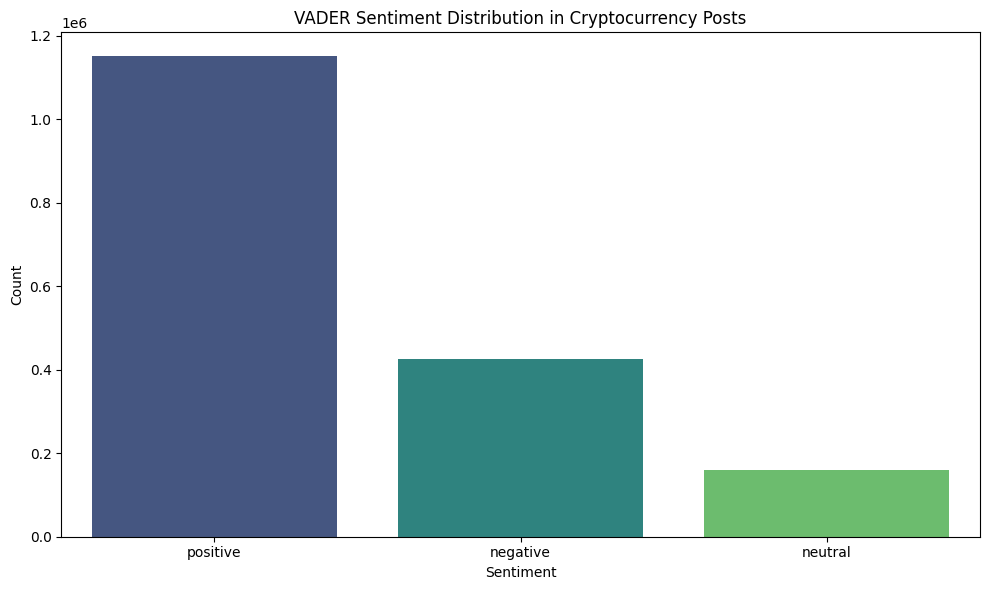

In [77]:

sid = SentimentIntensityAnalyzer()
for word, score in crypto_lexicon.items():
    sid.lexicon[word] = score

sentiment_df['vader_scores'] = sentiment_df['combined_text'].swifter.apply(
    lambda text: sid.polarity_scores(text) if isinstance(text, str) else {'compound': 0}
)

sentiment_df['vader_compound'] = sentiment_df['vader_scores'].swifter.apply(lambda score_dict: score_dict['compound'])

sentiment_df['vader_sentiment'] = sentiment_df['vader_compound'].swifter.apply(
    lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral')
)

vader_sentiment_counts = sentiment_df['vader_sentiment'].value_counts()
print("VADER Sentiment Distribution:")
print(vader_sentiment_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='vader_sentiment', data=sentiment_df, palette='viridis')
plt.title('VADER Sentiment Distribution in Cryptocurrency Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [86]:
sentiment_df["datetime"]=df["datetime"]
sentiment_df["subreddit"]=df["subreddit"]

### Prepare Data for Machine Learning

In [87]:
sentiment_df['sentiment_label'] = sentiment_df['vader_sentiment'].map({
    'positive': 1, 
    'neutral': 0, 
    'negative': -1
})

X = sentiment_df['cleaned_combined']
y = sentiment_df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")

Training data size: 1388972
Testing data size: 347243
Training features shape: (1388972, 5000)
Testing features shape: (347243, 5000)


## logistic regression

###  Train and Evaluate Logistic Regression

Training Logistic Regression classifier...
Logistic Regression Accuracy: 0.8208

Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Neutral       0.74      0.81      0.78     84801
    Positive       0.49      0.83      0.62     32220
    Negative       0.95      0.82      0.88    230222

    accuracy                           0.82    347243
   macro avg       0.73      0.82      0.76    347243
weighted avg       0.86      0.82      0.83    347243



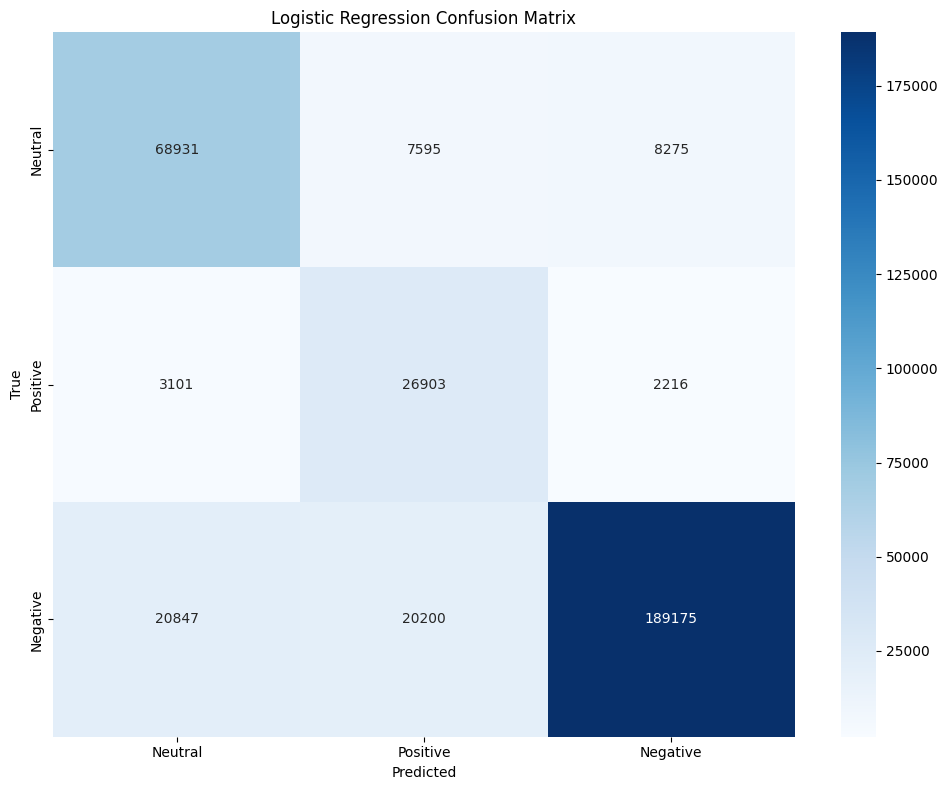

In [88]:
print("Training Logistic Regression classifier...")
lr_classifier = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
lr_classifier.fit(X_train_tfidf, y_train)


lr_predictions = lr_classifier.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions, target_names=['Neutral', 'Positive', 'Negative']))


plt.figure(figsize=(10, 8))
lr_cm = confusion_matrix(y_test, lr_predictions)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Neutral', 'Positive', 'Negative'],
           yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## naive bayes

### Train and Evaluate Naive Bayes

Training Naive Bayes classifier...
Naive Bayes Accuracy: 0.7456

Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Neutral       0.79      0.40      0.53     84801
    Positive       0.63      0.09      0.15     32220
    Negative       0.74      0.96      0.84    230222

    accuracy                           0.75    347243
   macro avg       0.72      0.48      0.51    347243
weighted avg       0.74      0.75      0.70    347243



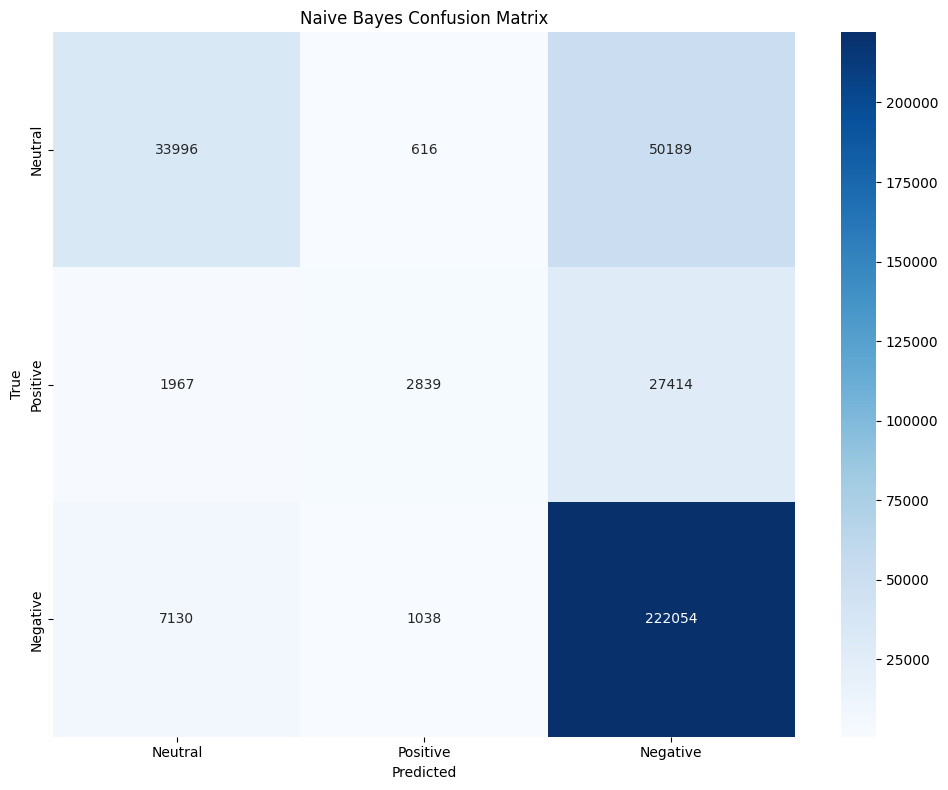

In [89]:
print("Training Naive Bayes classifier...")
nb_classifier = MultinomialNB(alpha=1.0)
nb_classifier.fit(X_train_tfidf, y_train)

nb_predictions = nb_classifier.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions, target_names=['Neutral', 'Positive', 'Negative']))

plt.figure(figsize=(10, 8))
nb_cm = confusion_matrix(y_test, nb_predictions)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Neutral', 'Positive', 'Negative'],
           yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## plotting top features for positive and negetive

### Feature Importance Analysis

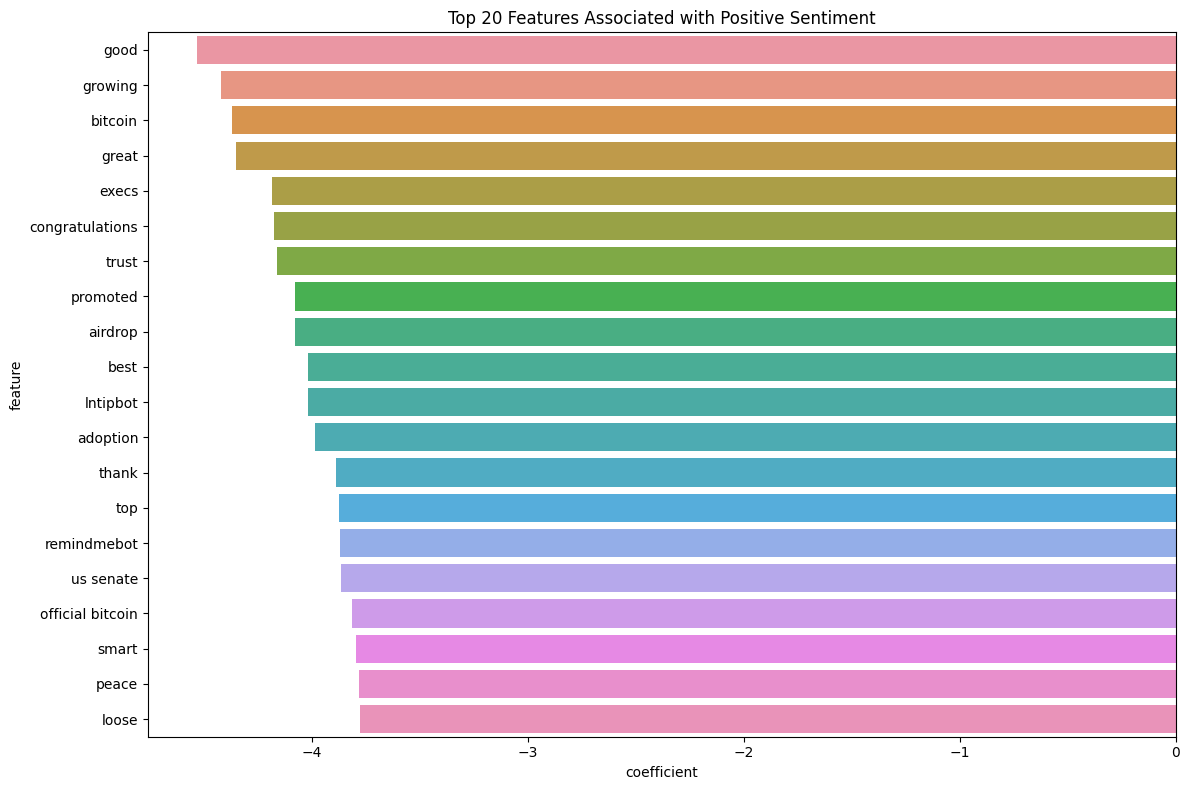

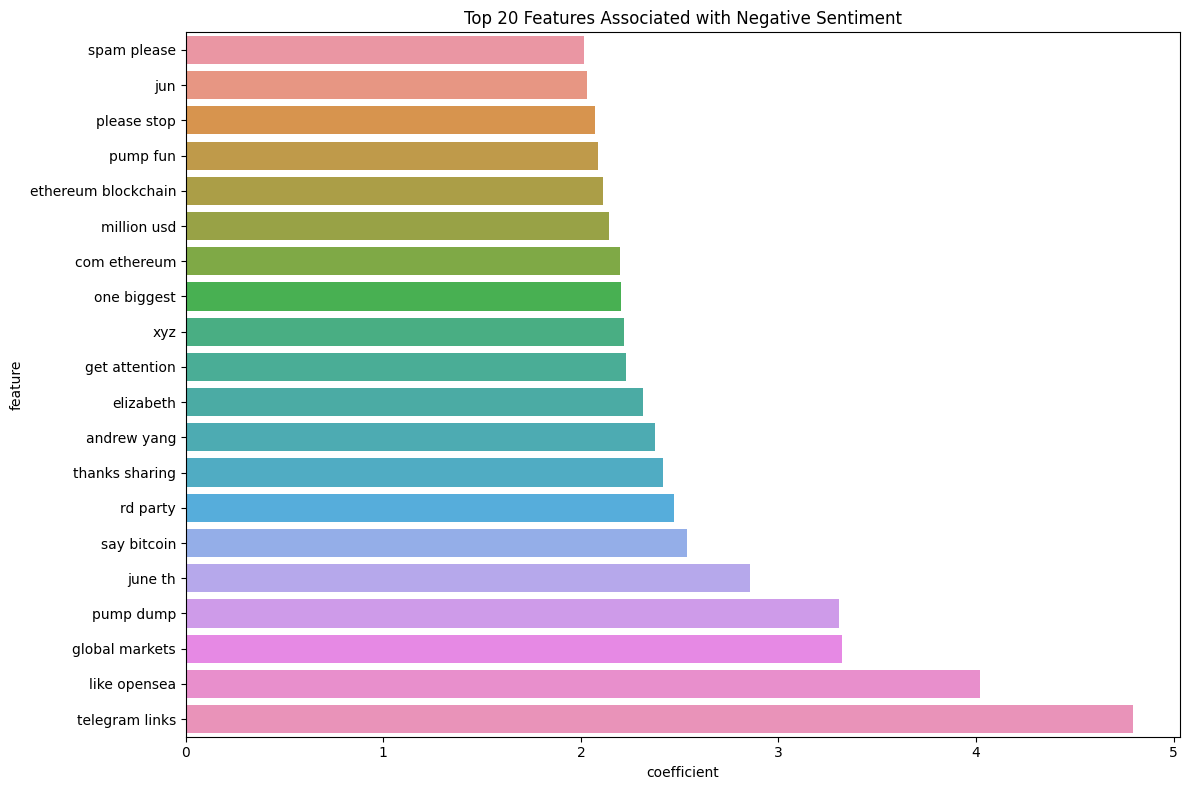

In [91]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_classifier.coef_[0] if lr_classifier.coef_.shape[0] == 1 else lr_classifier.coef_[1]  

top_positive_indices = np.argsort(coefficients)[:20]  # Top 20 positive features
top_negative_indices = np.argsort(coefficients)[-20:]   # Top 20 negative features

top_positive_df = pd.DataFrame({
    'feature': [feature_names[i] for i in top_positive_indices],
    'coefficient': coefficients[top_positive_indices]
})

top_negative_df = pd.DataFrame({
    'feature': [feature_names[i] for i in top_negative_indices],
    'coefficient': coefficients[top_negative_indices]
})

plt.figure(figsize=(12, 8))
sns.barplot(x='coefficient', y='feature', data=top_positive_df)
plt.title('Top 20 Features Associated with Positive Sentiment')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='coefficient', y='feature', data=top_negative_df)
plt.title('Top 20 Features Associated with Negative Sentiment')
plt.tight_layout()
plt.show()

### Apply Best Model to Full Dataset

In [92]:
best_model = lr_classifier if lr_accuracy >= nb_accuracy else nb_classifier
model_name = "Logistic Regression" if lr_accuracy >= nb_accuracy else "Naive Bayes"
print(f"Best model: {model_name} with accuracy: {max(lr_accuracy, nb_accuracy):.4f}")

all_tfidf = tfidf_vectorizer.transform(sentiment_df['cleaned_combined'])

sentiment_df['predicted_sentiment'] = best_model.predict(all_tfidf)

sentiment_df['predicted_sentiment_label'] = sentiment_df['predicted_sentiment'].map({
    1: 'positive',
    0: 'neutral',
    -1: 'negative'
})

sentiment_df['agreement'] = sentiment_df['vader_sentiment'] == sentiment_df['predicted_sentiment_label']
agreement_rate = sentiment_df['agreement'].mean()
print(f"\nAgreement rate between VADER and {model_name}: {agreement_rate:.4f}")

print("\nSample of sentiment analysis results:")
sentiment_df[['document_id', 'vader_compound', 'vader_sentiment', 
              'predicted_sentiment', 'predicted_sentiment_label']].head(10)

Best model: Logistic Regression with accuracy: 0.8208

Agreement rate between VADER and Logistic Regression: 0.8238

Sample of sentiment analysis results:


,document_id,vader_compound,vader_sentiment,predicted_sentiment,predicted_sentiment_label
1,1,0.9993,positive,1,positive
5,5,0.9933,positive,1,positive
6,6,0.9995,positive,1,positive
7,7,0.9965,positive,1,positive
8,8,0.9194,positive,1,positive
9,9,-0.6711,negative,-1,negative
10,10,-0.8847,negative,-1,negative
14,14,0.6360,positive,1,positive
15,15,0.9958,positive,1,positive
17,17,0.6369,positive,1,positive


In [93]:
sentiment_df.head()

,document_id,title,text,cleaned_title,cleaned_text,combined_text,cleaned_combined,vader_scores,vader_compound,vader_sentiment,datetime,subreddit,sentiment_label,predicted_sentiment,predicted_sentiment_label,agreement
1,1,FAQ for Beginners,----------------------------------------------...,faq beginners,bitcoin bitcoin scarce decentralized global di...,FAQ for Beginners ----------------------------...,faq beginners bitcoin bitcoin scarce decentral...,"{'neg': 0.055, 'neu': 0.733, 'pos': 0.211, 'co...",0.9993,positive,2020-04-19 05:49:55,bitcoinbeginners,1,1,positive,True
5,5,FAQ for Beginners,---------------------------------- **Some fou...,faq beginners,foundational principles security much value bi...,FAQ for Beginners ----------------------------...,faq beginners foundational principles security...,"{'neg': 0.052, 'neu': 0.803, 'pos': 0.145, 'co...",0.9933,positive,2020-04-28 15:25:45,bitcoinbeginners,1,1,positive,True
6,6,FAQ for Beginners,This subreddit is not a place where companies ...,faq beginners,subreddit place companies promote services pro...,FAQ for Beginners This subreddit is not a plac...,faq beginners subreddit place companies promot...,"{'neg': 0.087, 'neu': 0.715, 'pos': 0.198, 'co...",0.9995,positive,2020-04-19 17:34:10,bitcoinbeginners,1,1,positive,True
7,7,FAQ for Beginners,-------------------------------------------- *...,faq beginners,bitcoin beginners rules bitcoin beginners subr...,FAQ for Beginners ----------------------------...,faq beginners bitcoin beginners rules bitcoin ...,"{'neg': 0.089, 'neu': 0.729, 'pos': 0.182, 'co...",0.9965,positive,2020-04-19 17:35:40,bitcoinbeginners,1,1,positive,True
8,8,FAQ for Beginners,---------------------------------- **Common Q...,faq beginners,common questions happens bitcoin mined miners ...,FAQ for Beginners ----------------------------...,faq beginners common questions happens bitcoin...,"{'neg': 0.043, 'neu': 0.818, 'pos': 0.139, 'co...",0.9194,positive,2022-01-25 17:01:29,bitcoinbeginners,1,1,positive,True


## temporal sentiment analysis

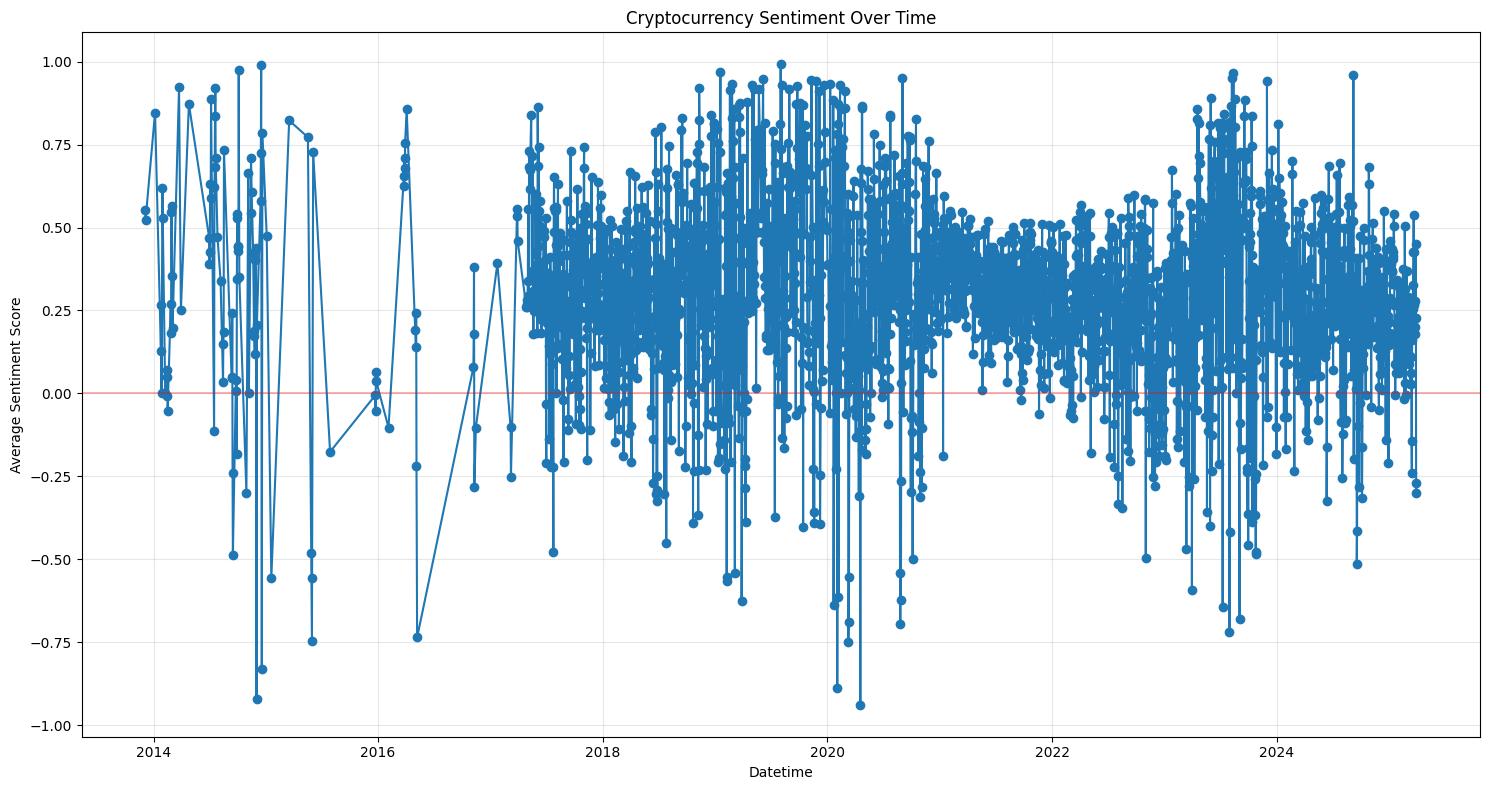

In [94]:
temporal_sentiment = sentiment_df.groupby(sentiment_df['datetime'].dt.date)['vader_compound'].mean().reset_index()
plt.figure(figsize=(15, 8))
plt.plot(temporal_sentiment['datetime'], temporal_sentiment['vader_compound'], marker='o')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Cryptocurrency Sentiment Over Time')
plt.xlabel('Datetime')
plt.ylabel('Average Sentiment Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Save Results 

In [95]:
sentiment_df.to_csv('sentiment_analysis_results.csv', index=False)


In [96]:
import joblib
joblib.dump(best_model, 'best_sentiment_model.pkl')

['best_sentiment_model.pkl']

In [97]:
df.to_pickle("preprocessed_reddit_data_1.pkl")
sentiment_df.to_pickle("sentiment_analysis_result_data.pkl")

In [1]:
df.head()

NameError: name 'df' is not defined